In [1]:
import sys, os
sys.path.insert(0, os.path.abspath("../../../"))

from dataclasses import dataclass
import typing as t 

import gymnasium as gym
import energydatamodel as edm
import emflow as ef

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FixedLocator, MultipleLocator

from pyomo.environ import AbstractModel,Set,Param,Var,Objective,Constraint,SolverFactory
from pyomo.environ import NonNegativeReals, PositiveReals, inequality
from pyomo.environ import value
solver_path = "/opt/homebrew/Cellar/cbc/2.10.7_1/bin/cbc"

from gse.gse import create_model, instantiate_model, solve_model, get_results
from gse.pyomo_input import create_static_input, create_dynamic_input

In [2]:
# Import data
df_load = pd.read_csv("./data/load.csv", index_col=0, parse_dates=True)
df_pv = pd.read_csv("./data/pv.csv", index_col=0, parse_dates=True)
df_price = pd.read_csv("./data/grid.csv", index_col=0, parse_dates=True)
df_battery = pd.read_csv("./data/battery.csv", index_col=0)

In [3]:
# What to do next? 
# 0. Create energy assets
# 1. Create the state space and action space classes
# 2. Create the objective function class. This should take in the state space and action space classes
# 3. Create the environment class
# 4. Create the problem class
# 5. Create the agent class
# 6. Create the instatiate the experiment class
# 7. Run the experiment
# 8. Get the results and save the results

In [4]:
# Create the energy assets
all_houses = df_load.columns
houses_with_pv = df_pv.columns
houses_with_battery = df_battery.columns

houses = []
for house_name in all_houses:
    house = edm.House(name=house_name, timeseries=edm.TimeSeries(df=df_load, column_name=house_name, filename="load.csv"))

    if house_name in houses_with_pv:
        pvsystem = edm.PVSystem(timeseries=edm.TimeSeries(df=df_pv, column_name=house_name, filename="pv.csv"))
        house.add_assets(pvsystem)

    if house_name in houses_with_battery:
        battery = edm.Battery(capacity_kwh=df_battery.loc["capacity", house_name],
                              min_soc_kwh=df_battery.loc["min soc", house_name],
                              max_charge_kw=df_battery.loc["charging power", house_name],
                              max_discharge_kw=df_battery.loc["discharging power", house_name],
                              charge_efficiency=df_battery.loc["charging efficiency", house_name],
                              discharge_efficiency=df_battery.loc["discharging efficiency", house_name])
        house.add_assets(battery)

    houses.append(house)

energycommunity = edm.EnergyCommunity(assets=houses)

In [5]:
# Should the time series be nd.arrays, pd.DataFrames or edm.TimeSeries?
@dataclass
class SingleHouseState: 
    time_range_index: pd.DatetimeIndex
    demand_timeseries: np.ndarray
    price_timeseries: np.ndarray
    pv_timeseries: t.Optional[np.ndarray] = None
    initial_battery_soc: t.Optional[float] = None
    final_battery_soc: t.Optional[float] = None

In [8]:
import dataclasses
dataclasses.asdict(SingleHouseState)

AttributeError: 'function' object has no attribute 'asdict'

In [14]:
from dataclasses import dataclass, fields
import gymnasium as gym
from gymnasium import spaces

@dataclass
class MyDataClass:
    name: spaces.Box(0, 1, shape=(2,))
    age: spaces.Box(0, 1, shape=(2,))
    is_student: spaces.Box(0, 1, shape=(2,))

def dataclass_to_dict(dc):
    return {field.name: field.type for field in fields(dc)}

# Convert the dataclass structure to a dictionary
dc_dict = dataclass_to_dict(MyDataClass)

s = spaces.Dict(dc_dict)

In [71]:
class SingleHouseEnvironment(gym.Env):

    def __init__(self, house, df_price, initial_battery_soc=None, final_battery_soc=None):
        self.house = house
        self.df_price = df_price
        self.initial_battery_soc = initial_battery_soc
        self.final_battery_soc = final_battery_soc

        self.state = None
        self.action = None
        self.reward = None
        self.done = False
        self.info = {}

    def step(self, action):
        # In this case, we will not calculate a next state.
        # We should check that the solution is feasible. Or should it be an Action method to check for feasibility?
        # Then we should return some sort of flag telling if the solution is feasible or not.

        pass
    
    def reset(self):
        self.state = SingleHouseState(time_range_index=house.timeseries.df.index,
                                      demand_timeseries=house.timeseries,
                                      price_timeseries=self.df_price)
        
        if self.house.has_pvsystem():
            pvsystem = house.get_pvsystems()[0]
            self.state.pv_timeseries = pvsystem.timeseries
        
        if self.house.has_battery():
            self.state.initial_battery_soc = self.initial_battery_soc
            self.state.final_battery_soc = self.final_battery_soc

        return self.state

    def render(self):
        # Plot the state
        pass

    def close(self):
        # Close the environment
        pass

In [72]:
@dataclass
class Action:
    # Somehow we want to constriain the action space using bounds. 
    # Maybe use the gym spaces class? Box then add attribute for index datatime
    # Should action include a method to check for feasibility?
    time_range_index: pd.DatetimeIndex
    power_buy: np.ndarray
    power_sell: np.ndarray
    battery_soc: t.Optional[np.ndarray] = None
    battery_charge: t.Optional[np.ndarray] = None
    battery_discharge: t.Optional[np.ndarray] = None  


In [77]:
# Instead of an Agent, this could also be an Optimizer? Doesn't matter.
class SingleHouseAgent:
    def __init__(self, house):
        self.house = house

        self.abstract_model = create_model()
        self.static_data = create_static_input(self.house)

    def action(self, state):
        
        # Create model data
        dynamic_data = create_dynamic_input(state, self.house)
        model_data = {None: {**self.static_data, **dynamic_data}}
        # Instantiate model with data
        model_instance = self.abstract_model.create_instance(model_data)
        # Solve model
        optimizer = SolverFactory("cbc", executable=solver_path)
        optimizer.solve(model_instance, tee=True, keepfiles=False)
        # Convert results to action
        power_buy = value(model_instance.PL1_BUY[:,house.name])
        power_sell = value(model_instance.PL1_SELL[:,house.name])
        battery_charge = value(model_instance.B_IN[:,house.name])
        battery_discharge = value(model_instance.B_OUT[:,house.name])
        battery_soc = value(model_instance.B_SOC[:,house.name])

        action = Action(time_range_index=state.time_range_index,
                        power_buy=power_buy, 
                        power_sell=power_sell,
                        battery_charge=battery_charge, 
                        battery_discharge=battery_discharge, 
                        battery_soc=battery_soc)

        return action
        

In [84]:
house = energycommunity.assets[0]

env = SingleHouseEnvironment(house=house, df_price=df_price, initial_battery_soc=0, final_battery_soc=0)
agent = SingleHouseAgent(house=house)

initial_state = env.reset()
action = agent.action(initial_state)

# env.step(action)
# obj.calculate(state, action)
# env.render()

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2024 

command line - /opt/homebrew/Cellar/cbc/2.10.7_1/bin/cbc -printingOptions all -import /var/folders/sj/xlrs69b568n4mntwz_7crr4r0000gn/T/tmpms7dw8f8.pyomo.lp -stat=1 -solve -solu /var/folders/sj/xlrs69b568n4mntwz_7crr4r0000gn/T/tmpms7dw8f8.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 8638 (-23042) rows, 20155 (-5765) columns and 34550 (-37449) elements
Statistics for presolved model


Problem has 8638 rows, 20155 columns (8639 with objective) and 34550 elements
There are 5760 singletons with objective 
Column breakdown:
11516 of type 0.0->inf, 8639 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
5758 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
2879 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of typ

In [87]:
action.__dict__.keys()

dict_keys(['time_range_index', 'power_buy', 'power_sell', 'battery_soc', 'battery_charge', 'battery_discharge'])

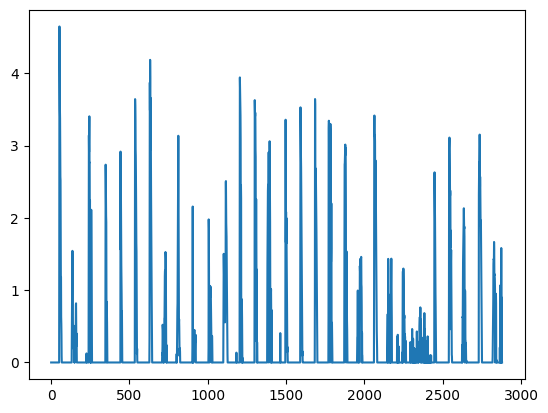

In [90]:
plt.plot(action.battery_charge)